In [1]:
import numpy as np

from inspiralfuns import *

In [2]:
#GW150914-like
logMc=1.4
q=0.8

#defaults
flow=10.0
merger_type='BH'
D=100.0

M, eta = get_M_and_eta(logMc=logMc,q=q)
start_x = startx(M,flow)
end_x = endx(eta,merger_type)

In [3]:
x, xtimes, dt = x_integration(start_x,end_x,M,eta)

In [4]:
realtimes = inspiral_time_conversion(xtimes,M)

In [5]:
i_phase, omega, freq = inspiral_phase_freq_integration(x,dt,M)

In [6]:
r, rdot = radius_calculation(x,M,eta)

In [7]:
A1, A2 = a1_a2_calculation(r,rdot,omega,D,M,eta)

In [8]:
Aorth, Adiag = inspiral_strain_polarisations(A1,A2,i_phase)

In [9]:
i_amp = inspiral_strain_amplitude(Aorth,Adiag)

In [31]:
import matplotlib.pyplot as plt

In [27]:
"""
plt.figure(1)
plt.plot(realtimes,i_amp)
plt.xlabel('Time (s)')
plt.ylabel('Strain amplitude')

plt.figure(2)
plt.plot(freq,i_amp)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Strain amplitude')
"""

"\nimport matplotlib.pyplot as plt\n\nplt.figure(1)\nplt.plot(realtimes,i_amp)\nplt.xlabel('Time (s)')\nplt.ylabel('Strain amplitude')\n\nplt.figure(2)\nplt.plot(freq,i_amp)\nplt.xlabel('Frequency (Hz)')\nplt.ylabel('Strain amplitude')\n"

In [28]:
"""
plt.figure(1)
plt.plot(realtimes,Aorth)
plt.plot(realtimes,Adiag)
plt.xlabel('Time (s)')
plt.ylabel('Strain polarisations')
"""

"\nplt.figure(1)\nplt.plot(realtimes,Aorth)\nplt.plot(realtimes,Adiag)\nplt.xlabel('Time (s)')\nplt.ylabel('Strain polarisations')\n"

In [11]:
i_time = list_size_reducer(100,realtimes)
i_omega = list_size_reducer(100,omega)
i_phase = list_size_reducer(100,i_phase)
i_amp = list_size_reducer(100,i_amp)

In [12]:
from mergerfirstfuns import *

In [13]:
sfin, wqnm = quasi_normal_modes(eta)
alpha, b, C, kappa = gIRS_coefficients(eta,sfin)

In [14]:
fhat, m_omega = merger_freq_calculation(wqnm,b,C,kappa)

In [15]:
fhatdot = fhat_differentiation(fhat)

In [16]:
m_time = merger_time_conversion(M)

In [17]:
from matchingfuns import *

In [18]:
min_switch_ind = min_switch_ind_finder(i_time,i_omega,m_time,m_omega)

In [19]:
final_i_index = final_i_index_finder(min_switch_ind,i_omega,m_omega)
time_offset = time_offset_finder(min_switch_ind,final_i_index,i_time,m_time)

In [20]:
i_m_time, i_m_omega = time_frequency_stitching(min_switch_ind,final_i_index,time_offset,i_time,i_omega,m_time,m_omega)

In [22]:
i_m_freq = frequency_SI_units(i_m_omega,M)

In [23]:
from mergersecondfuns import *

In [24]:
m_phase = merger_phase_calculation(min_switch_ind,final_i_index,i_phase,m_omega)

In [25]:
i_m_phase = phase_stitching(final_i_index,i_phase,m_phase)

In [29]:
m_amp = merger_strain_amplitude(min_switch_ind,final_i_index,alpha,i_amp,m_omega,fhat,fhatdot)

In [30]:
i_m_amp = amplitude_stitching(final_i_index,i_amp,m_amp)

Text(0, 0.5, 'Strain amplitude')

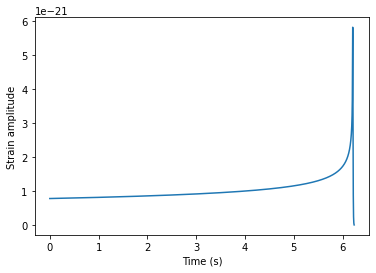

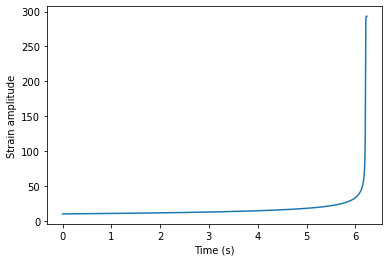

In [32]:
plt.figure(1)
plt.plot(i_m_time,i_m_amp)
plt.xlabel('Time (s)')
plt.ylabel('Strain amplitude')

plt.figure(2)
plt.plot(i_m_time,i_m_freq)
plt.xlabel('Time (s)')
plt.ylabel('Strain amplitude')